# Catboost

In [1]:
import pandas as pd
import os
import random
import numpy as np

## 1. 데이터 로딩

In [2]:
data_dir = '/opt/ml/input/data' # data 경로 지정
csv_file_path = os.path.join(data_dir, 'train_data.csv')
df = pd.read_csv(csv_file_path, parse_dates=["Timestamp"]) 

## 2. Feature Engineering

In [3]:
from feature_engineering import get_features

df = get_features(df)
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,correct_shift_-2,...,relative_time,test_mean,test_sum,tag_mean,tag_sum,assess_mean,assess_sum,user_mean,user_sum,correct_per_hour
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,1.0,...,-27.0,0.947683,1268,0.955022,637,0.982063,219,0.630872,470,0.649446
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.0,1.0,...,-24.0,0.947683,1268,0.913187,3040,0.964126,215,0.630872,470,0.649446
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.0,1.0,...,-19.0,0.947683,1268,0.913187,3040,0.910314,203,0.630872,470,0.649446
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3.0,3,1.0,1.0,...,-20.0,0.947683,1268,0.913187,3040,0.968610,216,0.630872,470,0.649446
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4.0,4,1.0,0.0,...,-20.0,0.947683,1268,0.913187,3040,0.941704,210,0.630872,470,0.649446


## 3. Train/Test 데이터 셋 분리

In [4]:
from util import setSeeds, custom_train_test_split, get_eval

setSeeds(42)

# 유저별 분리
train, test = custom_train_test_split(df, ratio=0.99)

In [5]:
# 사용할 Feature 설정

cate_cols=[#"assessmentItemID", 
           #"testId", 
           "KnowledgeTag", 
           "correct_shift_-2", 
           "correct_shift_-1", 
           "correct_shift_1", 
           "correct_shift_2",
           #"hour", 
           "hour_mode",                 
           ]
    
cont_cols=["user_acc", 
           #"user_correct_answer", 
           #"user_total_answer", 
           #"future_correct", 
           "average_content_correct", 
           "mean_time", 
           #"time_median",
           #"correct_per_hour", 
           "time", 
           #"normalized_time",
           #"relative_time", 
           "assess_mean", 
           "assess_sum", 
           "tag_mean", 
           "tag_sum", 
           "test_mean", 
           "test_sum",
           "user_mean",
           #"user_sum",
           ]
           
FEATS = cate_cols + cont_cols

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [6]:
train

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,correct_shift_-2,correct_shift_-1,...,relative_time,test_mean,test_sum,tag_mean,tag_sum,assess_mean,assess_sum,user_mean,user_sum,correct_per_hour
0,0,A060001001,A060000001,2020-03-24 00:17:11,7224,NaN,0,NaN,1.0,1.0,...,-27.0,0.947683,1268,0.955022,637,0.982063,219,0.630872,470,0.649446
1,0,A060001002,A060000001,2020-03-24 00:17:14,7225,1.0,1,1.000000,1.0,1.0,...,-24.0,0.947683,1268,0.913187,3040,0.964126,215,0.630872,470,0.649446
2,0,A060001003,A060000001,2020-03-24 00:17:22,7225,2.0,2,1.000000,1.0,1.0,...,-19.0,0.947683,1268,0.913187,3040,0.910314,203,0.630872,470,0.649446
3,0,A060001004,A060000001,2020-03-24 00:17:29,7225,3.0,3,1.000000,1.0,1.0,...,-20.0,0.947683,1268,0.913187,3040,0.968610,216,0.630872,470,0.649446
4,0,A060001005,A060000001,2020-03-24 00:17:36,7225,4.0,4,1.000000,0.0,1.0,...,-20.0,0.947683,1268,0.913187,3040,0.941704,210,0.630872,470,0.649446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,2020-06-05 06:50:21,438,1.0,4,0.250000,1.0,1.0,...,-16.0,0.662590,921,0.689706,2814,0.435252,121,0.555556,5,0.629941
2266582,7441,A040165001,A040000165,2020-08-21 01:06:39,8836,1.0,5,0.200000,1.0,1.0,...,6632138.0,0.655109,718,0.697874,2199,0.649635,178,0.555556,5,0.644321
2266583,7441,A040165002,A040000165,2020-08-21 01:06:50,8836,2.0,6,0.333333,1.0,1.0,...,-29.0,0.655109,718,0.697874,2199,0.635036,174,0.555556,5,0.644321
2266584,7441,A040165003,A040000165,2020-08-21 01:07:36,8836,3.0,7,0.428571,NaN,1.0,...,6.0,0.655109,718,0.697874,2199,0.791971,217,0.555556,5,0.644321


In [7]:
X_train = train[FEATS]
X_test = test[FEATS]

## 4. 훈련 및 검증

In [8]:
#!pip install catboost

In [9]:
from catboost import CatBoostClassifier, Pool

train_data = Pool(data=X_train, label=y_train)
test_data = Pool(data=X_test, label=y_test)

In [10]:
params = {'loss_function':'Logloss', # objective function
          'iterations': 1000,
          'eval_metric':'AUC', # metric
          'learning_rate': 0.01,
          'random_seed': 42
         }

model = CatBoostClassifier(**params)

model.fit(train_data, # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=test_data, # data to validate on
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
          plot=True # True for visualization of the training process (it is not shown in a published kernel - try executing this code)
         )

pred_probs = model.predict(test_data)

get_eval(y_test, np.where(pred_probs>=0.5, 1, 0))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7790179	best: 0.7790179 (0)	total: 193ms	remaining: 3m 12s
1:	test: 0.7795759	best: 0.7795759 (1)	total: 327ms	remaining: 2m 43s
2:	test: 0.7801339	best: 0.7801339 (2)	total: 462ms	remaining: 2m 33s
3:	test: 0.7829241	best: 0.7829241 (3)	total: 594ms	remaining: 2m 27s
4:	test: 0.8013393	best: 0.8013393 (4)	total: 729ms	remaining: 2m 25s
5:	test: 0.7896205	best: 0.8013393 (4)	total: 876ms	remaining: 2m 25s
6:	test: 0.7896205	best: 0.8013393 (4)	total: 1.01s	remaining: 2m 24s
7:	test: 0.7885045	best: 0.8013393 (4)	total: 1.15s	remaining: 2m 22s
8:	test: 0.7885045	best: 0.8013393 (4)	total: 1.28s	remaining: 2m 21s
9:	test: 0.7929688	best: 0.8013393 (4)	total: 1.42s	remaining: 2m 20s
10:	test: 0.7907366	best: 0.8013393 (4)	total: 1.56s	remaining: 2m 20s
11:	test: 0.7896205	best: 0.8013393 (4)	total: 1.7s	remaining: 2m 20s
12:	test: 0.7896205	best: 0.8013393 (4)	total: 1.86s	remaining: 2m 21s
13:	test: 0.7901786	best: 0.8013393 (4)	total: 2s	remaining: 2m 20s
14:	test: 0.7901786	

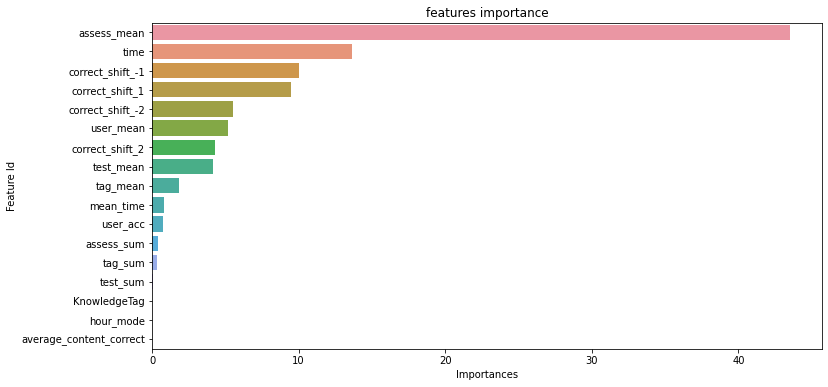

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Create a dataframe of feature importance 
df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True))
#plotting feature importance
plt.figure(figsize=(12, 6));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance);
plt.title('features importance');

## 5. Inference

In [12]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path, parse_dates=["Timestamp"])

# FEATURE ENGINEERING
test_df = get_features(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]
y_test_df = test_df['answerCode']

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

cat_test_df = Pool(data=test_df[FEATS])

In [13]:
# MAKE PREDICTION
total_preds = model.predict(cat_test_df)

In [14]:
# SAVE OUTPUT
output_dir = '/opt/ml/output/' # output directory 지정
write_path = os.path.join(output_dir, "catboost.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : /opt/ml/output/catboost.csv
